## 项目介绍与数据集分析处理

![](./images/01-1.png)

### 1. 项目背景介绍

随着人工智能技术的发展，构建能够进行流畅、有逻辑、多轮对话的智能系统成为了热门方向。Transformer 架构，凭借其强大的自注意力机制，在序列建模任务上取得了突破性进展。然而，仅仅能够生成连贯回复的对话系统是不够的，真正有用的对话系统还需要具备**情感理解与共情能力**，能够理解用户的情感状态，并给出富有同理心的回复。

**共情对话（Empathetic Dialogue）** 是指对话系统能够识别和理解对话者的情感状态，并以适当的情感回应进行对话。这种能力对于构建人性化的AI助手、心理健康支持系统、客服机器人等应用场景至关重要。

本项目通过训练一个基于 **Transformer** 模型的文本生成器，实现多轮对话，并通过以下方法实现了更好的共情对话：

1. **Transformer架构**：利用自注意力机制解决长距离依赖问题，实现更好的上下文理解
2. **多分辨率情感建模**：同时考虑粗粒度情感（如快乐、悲伤）和细粒度情感表达
3. **交互式判别器**：使用对抗训练机制提升生成回复的质量和情感适当性  

通过本项目，学生将以零开始逐步搭建模型的方式学习：
- Transformer的核心组件（自注意力、多头注意力、位置编码等）
- 共情对话系统的设计原理和实现方法
- 情感分析与情感生成的结合
- 对抗训练在对话生成中的应用
- 如何评估对话系统的情感表达能力

该项目不仅具有重要的学习价值，在实际应用中也有广阔前景，能够应用于智能客服、心理健康咨询、教育辅导等多个领域。

### 2. 运行环境和数据准备

首先，安装环境依赖包，在终端中运行
```bash
pip install -r resquirements.txt
```

虽然通过上一步骤，我们安装了 **NLTK** 这一自然语言处理库，但我们还需要手动下载 [**NLTK_data 数据包**](https://github.com/nltk/nltk_data/tree/gh-pages/packages) 将其放在环境中或项目目录下（已准备好）。

接着，我们需要从[**该链接 (glove.6B.300d.txt)**](http://nlp.stanford.edu/data/glove.6B.zip)下载 **GloVe vectors** 并将其放入 ./vectors/ 中（已准备好）。

**什么是GloVe vectors？**

**GloVe** 是由斯坦福大学在2014年提出的一种**无监督学习算法**，用于学习单词的向量表示。它的全称是"Global Vectors for Word Representation"（全局词向量表示）。

核心原理：
- **基于全局统计信息**：不同于 Word2vec 只使用局部上下文信息，GloVe 利用整个语料库的**全局词语共现统计**
- **词语共现矩阵**：分析词语在大型文本语料中一起出现的频率
- **概率比值**：通过词语共现概率的比值来捕获语义关系

例如：
- 如果"ice"（冰）和"solid"（固体）共同出现的概率较高
- 而"steam"（蒸汽）和"gas"（气体）共同出现的概率较高  
- 那么这些比值关系能够揭示词语之间的语义联系

**GloVe vectors的作用是什么？**

1. **词语语义表示**
- 将词语转换为高维向量（如300维）
- 语义相似的词在向量空间中距离更近
- 例如："king" - "man" + "woman" ≈ "queen"
2. **在自然语言处理任务中的应用**
- **文本分类**：理解文档主题和情感
- **命名实体识别**：识别人名、地名等实体
- **问答系统**：理解问题和答案的语义关系
- **机器翻译**：捕获不同语言间的语义对应关系
3. **在本项目中的具体作用**
在本共情对话生成项目中，GloVe vectors起到以下关键作用：
- **语义理解**：帮助模型理解对话中词语的真实含义
- **情感捕获**：通过词向量表示情感色彩和语境
- **上下文建模**：为Transformer等模型提供丰富的词语表示
- **预训练知识**：利用大规模语料训练的词向量，提供通用的语言知识

最后，需要在终端中运行
```bash
wget https://dl.fbaipublicfiles.com/parlai/empatheticdialogues/empatheticdialogues.tar.gz
```
或者运行
```bash
python ./utils/dataset_download.py
```
下载官方的 Empathetic Dialogues 数据集，并将其放在 ./empathetic-dialogue/ 路径下。

### 3. 数据集介绍与分析处理

#### 3.1 Empathetic Dialogues 数据集概述

**Empathetic Dialogues**数据集是由Facebook AI Research在2019年发布的大规模共情对话数据集，旨在训练能够识别和回应人类情感的对话系统。数据集的论文链接：[Towards Empathetic Open-domain Conversation Models: a New Benchmark and Dataset](https://arxiv.org/pdf/1811.00207)。

**数据集特点：**

1. **情感驱动的对话收集**：不同于传统的开放域对话数据集，该数据集专门针对情感表达和共情回应进行设计
2. **情境化对话**：每个对话都基于特定的情感情境，使对话更加真实自然
3. **多样化情感标签**：涵盖32种不同的情感状态，包括高兴、悲伤、愤怒、惊讶等


**数据集的挑战与价值：**

**主要挑战：**
1. **情感理解复杂性**：需要准确识别微妙的情感表达
2. **上下文相关性**：回复需要与对话历史和情感状态保持一致
3. **共情表达**：生成的回复需要体现出合适的同理心
4. **多样性要求**：避免生成重复或通用的回复

**研究价值：**
- 为共情对话生成研究提供标准化评估基准
- 推动情感计算和自然语言处理的交叉研究
- 为构建更人性化的AI系统奠定数据基础
- 支持心理健康、客服、教育等应用领域的发展

该数据集已成为共情对话生成领域的重要基准，被广泛用于训练和评估各种共情对话模型。

#### 3.2 数据集分析
下面我们来对数据集进行分析处理。

- 导入相关库，并进行中文显示验证。

已设置中文字体: SimHei


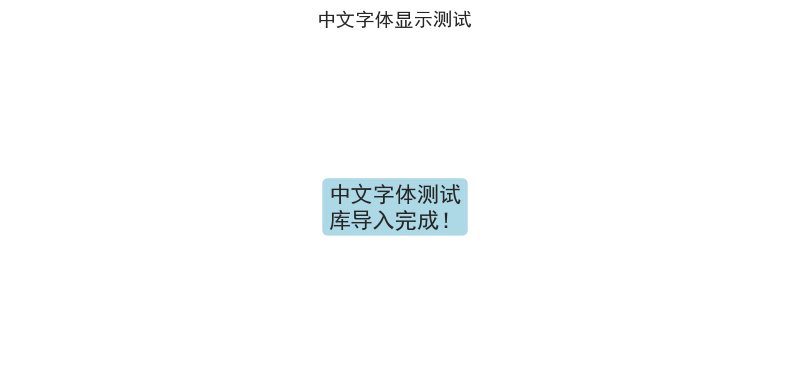

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
import re
from wordcloud import WordCloud
import warnings
import platform
import matplotlib.font_manager as fm
from matplotlib.font_manager import FontProperties
warnings.filterwarnings('ignore')

# 设置matplotlib参数以支持中文显示
plt.rcParams['axes.unicode_minus'] = False  # 解决坐标轴负号显示问题

# 根据操作系统设置中文字体
system = platform.system()
if system == "Windows":
    # Windows系统常用中文字体
    font_options = ['SimHei', 'Microsoft YaHei', 'KaiTi', 'SimSun', 'FangSong']
    for font in font_options:
        try:
            plt.rcParams['font.sans-serif'] = [font, 'DejaVu Sans']
            plt.rcParams['font.family'] = 'sans-serif'
            print(f"已设置中文字体: {font}")
            break
        except:
            continue
elif system == "Darwin":  # macOS
    plt.rcParams['font.sans-serif'] = ['Heiti TC', 'PingFang SC', 'Hiragino Sans GB', 'Arial Unicode MS', 'DejaVu Sans']
    plt.rcParams['font.family'] = 'sans-serif'
    print("已设置macOS中文字体")
else:  # Linux
    plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei', 'WenQuanYi Zen Hei', 'Noto Sans CJK SC', 'DejaVu Sans']
    plt.rcParams['font.family'] = 'sans-serif'
    print("已设置Linux中文字体")

# 测试中文字体显示
def test_chinese_font():
    """测试中文字体是否能正常显示"""
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.text(0.5, 0.5, '中文字体测试\n库导入完成！', 
            fontsize=16, ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title('中文字体显示测试', fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# 运行测试
test_chinese_font()


- 加载数据集

In [21]:
def load_empathetic_dialogue_data():
    """安全地加载empathetic dialogue数据集"""
    train_df = pd.read_csv(
        r'empathetic-dialogue\train.csv',
        encoding='utf-8',
        quotechar='"',
        skipinitialspace=True,
        on_bad_lines='skip',
        engine='python'
    )
    
    test_df = pd.read_csv(
        r'empathetic-dialogue\test.csv',
        encoding='utf-8',
        quotechar='"',
        skipinitialspace=True,
        on_bad_lines='skip',
        engine='python'
    )
    
    valid_df = pd.read_csv(
        r'empathetic-dialogue\valid.csv',
        encoding='utf-8',
        quotechar='"',
        skipinitialspace=True,
        on_bad_lines='skip',
        engine='python'
    )
    
    print("数据加载完成！")
    print(f"训练集大小: {train_df.shape}")
    print(f"测试集大小: {test_df.shape}")
    print(f"验证集大小: {valid_df.shape}")
    print(f"总数据量: {train_df.shape[0] + test_df.shape[0] + valid_df.shape[0]} 条记录")
    
    return train_df, test_df, valid_df

# 加载数据
train_df, test_df, valid_df = load_empathetic_dialogue_data()

数据加载完成！
训练集大小: (76488, 8)
测试集大小: (5695, 8)
验证集大小: (6313, 8)
总数据量: 88496 条记录


- 分析情感标签分布

=== 情感标签分布 ===
context
surprised       4574
excited         3354
proud           3117
annoyed         3115
angry           3111
sad             3054
lonely          2881
afraid          2875
grateful        2867
terrified       2832
disgusted       2823
confident       2815
anxious         2807
impressed       2787
anticipating    2773
guilty          2762
hopeful         2759
disappointed    2753
joyful          2718
furious         2714
jealous         2709
nostalgic       2701
prepared        2680
content         2583
embarrassed     2578
devastated      2512
sentimental     2462
caring          2392
trusting        2311
ashamed         2267
apprehensive    2146
faithful        1664
Name: count, dtype: int64


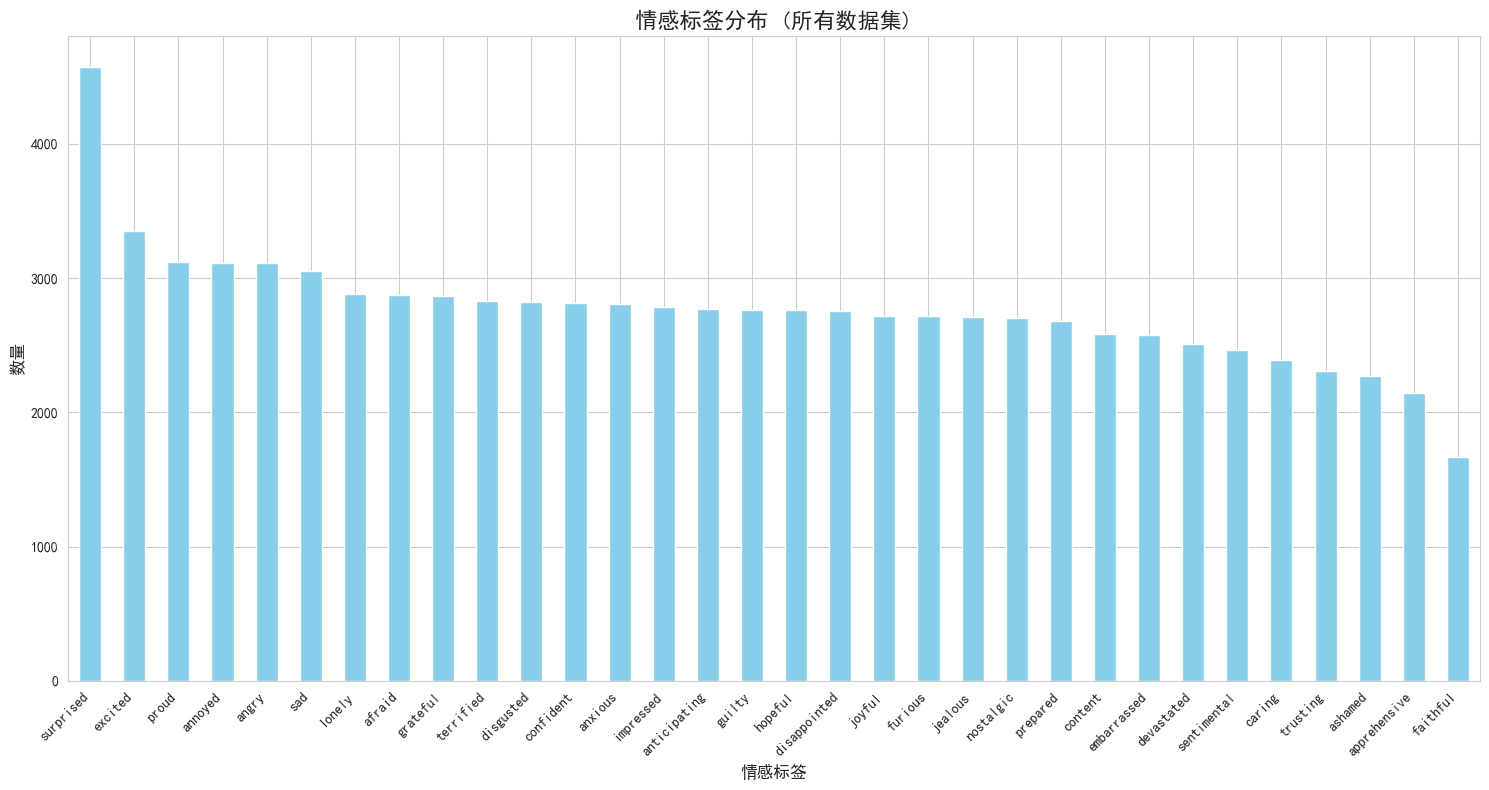

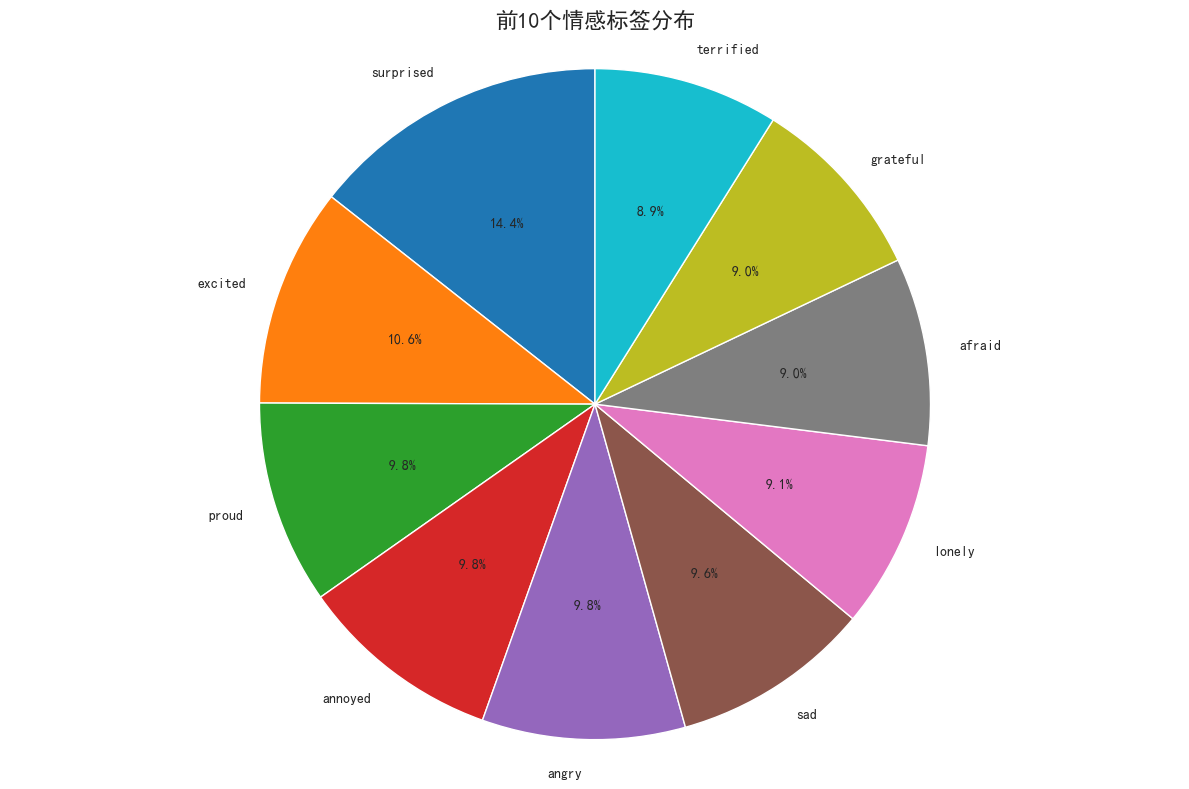

In [22]:
def analyze_emotion_distribution():
    # 合并数据集进行整体分析
    all_data = pd.concat([train_df, test_df, valid_df], ignore_index=True)
    
    # 统计情感标签分布
    emotion_counts = all_data['context'].value_counts()
    
    print("=== 情感标签分布 ===")
    print(emotion_counts)
    
    # 绘制情感分布柱状图
    plt.figure(figsize=(15, 8))
    emotion_counts.plot(kind='bar', color='skyblue')
    plt.title('情感标签分布 (所有数据集)', fontsize=16)
    plt.xlabel('情感标签', fontsize=12)
    plt.ylabel('数量', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # 绘制情感分布饼图（前10个）
    plt.figure(figsize=(12, 8))
    top_emotions = emotion_counts.head(10)
    plt.pie(top_emotions.values, labels=top_emotions.index, autopct='%1.1f%%', startangle=90)
    plt.title('前10个情感标签分布', fontsize=16)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    return emotion_counts

emotion_distribution = analyze_emotion_distribution()


- 统计数据集中的对话轮次

=== 对话轮次统计 ===
平均对话轮次: 4.13
最大对话轮次: 8
最小对话轮次: 1
对话轮次标准差: 0.85


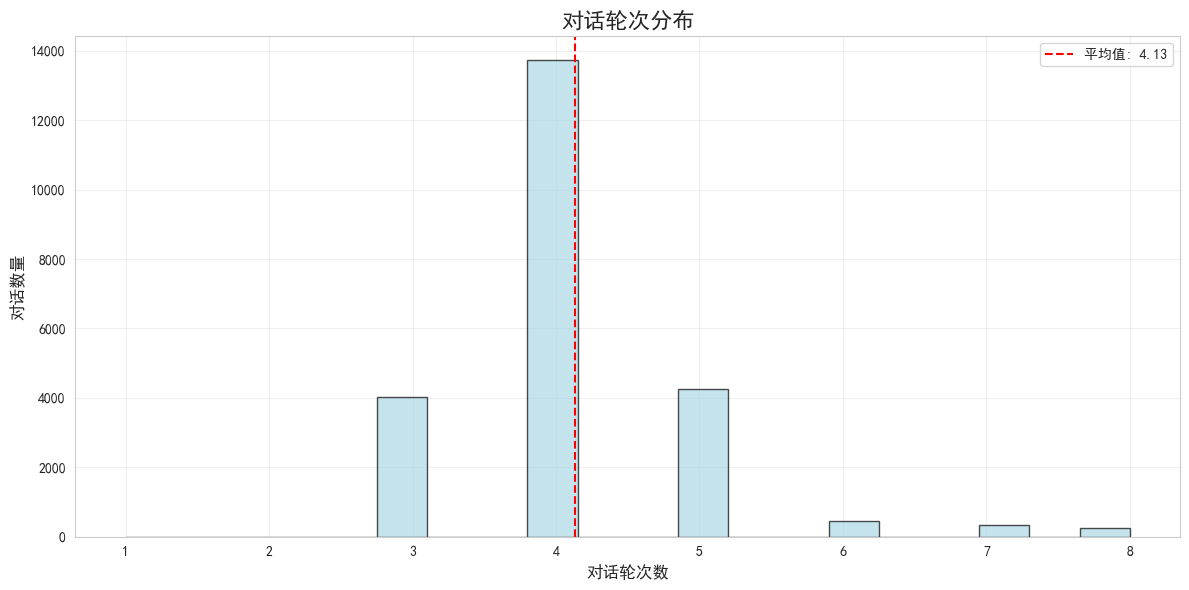


=== 说话者分布 ===
speaker_idx
27     2808
1      2580
126    1937
4      1885
238    1735
       ... 
510       2
802       2
195       2
522       2
414       2
Name: count, Length: 788, dtype: int64


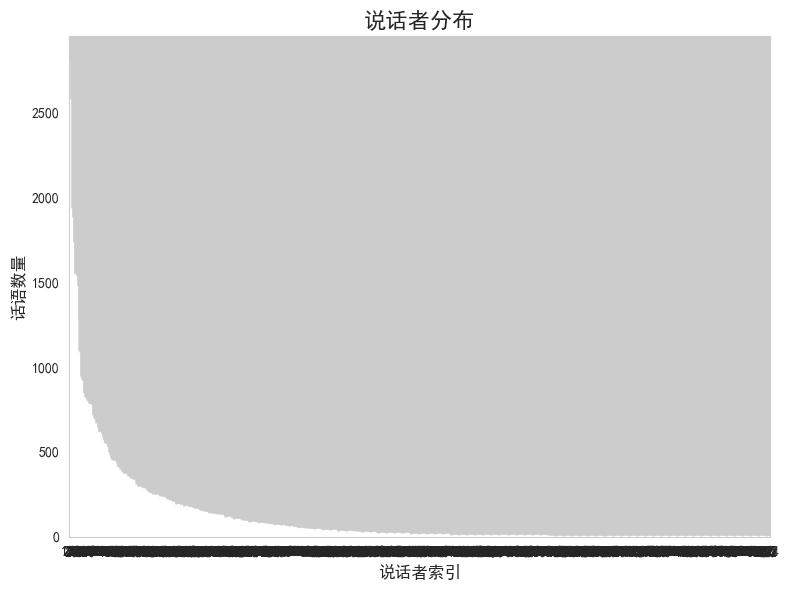

In [23]:
def analyze_conversation_turns():
    # 合并所有数据集
    all_data = pd.concat([train_df, test_df, valid_df], ignore_index=True)
    
    # 统计每个对话的轮次数
    conv_turns = all_data.groupby('conv_id')['utterance_idx'].max()
    
    print("=== 对话轮次统计 ===")
    print(f"平均对话轮次: {conv_turns.mean():.2f}")
    print(f"最大对话轮次: {conv_turns.max()}")
    print(f"最小对话轮次: {conv_turns.min()}")
    print(f"对话轮次标准差: {conv_turns.std():.2f}")
    
    # 绘制对话轮次分布直方图
    plt.figure(figsize=(12, 6))
    plt.hist(conv_turns, bins=20, edgecolor='black', alpha=0.7, color='lightblue')
    plt.title('对话轮次分布', fontsize=16)
    plt.xlabel('对话轮次数', fontsize=12)
    plt.ylabel('对话数量', fontsize=12)
    plt.axvline(conv_turns.mean(), color='red', linestyle='--', 
                label=f'平均值: {conv_turns.mean():.2f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 说话者分布分析
    speaker_dist = all_data['speaker_idx'].value_counts()
    print("\n=== 说话者分布 ===")
    print(speaker_dist)
    
    plt.figure(figsize=(8, 6))
    speaker_dist.plot(kind='bar', color=['lightcoral', 'lightgreen'])
    plt.title('说话者分布', fontsize=16)
    plt.xlabel('说话者索引', fontsize=12)
    plt.ylabel('话语数量', fontsize=12)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return conv_turns

conversation_turns = analyze_conversation_turns()


- 统计分析对话文本中的词频

=== 前20个高频词 ===
just: 6771
really: 5836
not: 5701
get: 5477
like: 5411
good: 5404
about: 4788
time: 4468
all: 4381
got: 3763
one: 3591
going: 3587
know: 3572
very: 3459
too: 3459
there: 3241
feel: 3151
some: 3144
think: 3131
well: 3120


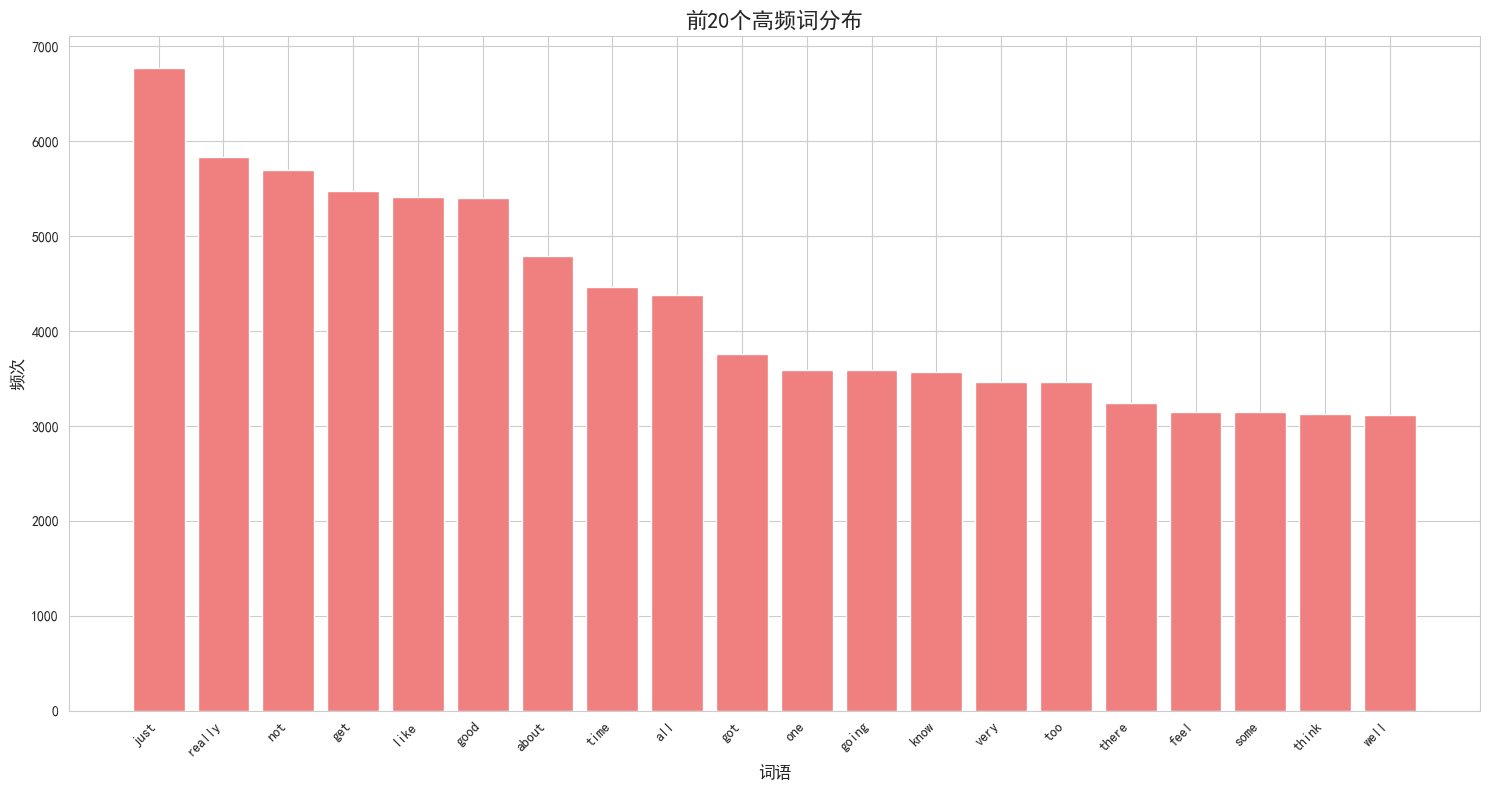

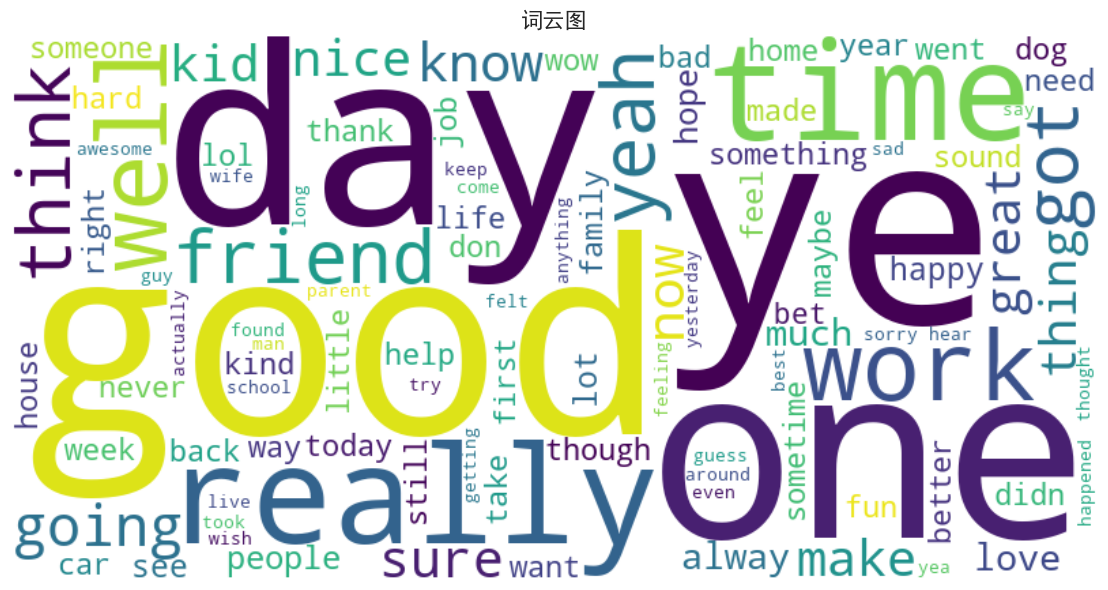

In [24]:
def analyze_word_frequency():
    # 合并数据集
    all_data = pd.concat([train_df, test_df, valid_df], ignore_index=True)
    
    # 合并话语文本
    all_text = ' '.join(all_data['utterance'].astype(str))
    
    # 数据清理：移除标点符号、转换为小写
    clean_text = re.sub(r'[^\w\s]', ' ', all_text.lower())
    clean_text = re.sub(r'_comma_', ',', clean_text)  # 恢复逗号
    words = clean_text.split()
    
    # 移除常见停用词
    stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by',
                  'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'do', 'does', 'did',
                  'will', 'would', 'could', 'should', 'may', 'might', 'must', 'can', 'shall', 'i', 'you', 'he',
                  'she', 'it', 'we', 'they', 'me', 'him', 'her', 'us', 'them', 'my', 'your', 'his', 'her',
                  'its', 'our', 'their', 'this', 'that', 'these', 'those', 'what', 'which', 'who', 'when',
                  'where', 'why', 'how', 'if', 'so', 'as', 'up', 'out', 'off', 'over', 'under', 'again',
                  'further', 'then', 'once'}
    
    filtered_words = [word for word in words if word not in stop_words and len(word) > 2]
    
    # 统计词频
    word_freq = Counter(filtered_words)
    
    print("=== 前20个高频词 ===")
    top_words = word_freq.most_common(20)
    for word, count in top_words:
        print(f"{word}: {count}")
    
    # 绘制词频柱状图
    plt.figure(figsize=(15, 8))
    words_list, counts_list = zip(*top_words)
    plt.bar(words_list, counts_list, color='lightcoral')
    plt.title('前20个高频词分布', fontsize=16)
    plt.xlabel('词语', fontsize=12)
    plt.ylabel('频次', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # 生成词云
    try:
        wordcloud = WordCloud(width=800, height=400, 
                             background_color='white',
                             max_words=100,
                             colormap='viridis').generate(' '.join(filtered_words))
        
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('词云图', fontsize=16)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"词云生成失败: {e}")
    
    return word_freq

word_frequency = analyze_word_frequency()


#### 3.3 数据清洗与处理

代码目录：
- ./utils/get_ed_data.py
- ./utils/data_reader.py

运行 empathetic-dialogue 目录下的 `get_ed_data.py` 脚本，对原始的对话数据集进行数据清洗并重组为本项目所需的多视角样本，构建词表，并将结果序列化为 .npyl 供加载使用。
```bash
python ./utils/get_ed_data.py
```

`get_ed_data.py` 对原始 CSV 文件（train.csv／valid.csv／test.csv）处理的整体流程：

1. 参数解析  
   - 通过 `setup_args` 构造并解析数据集所需的命令行参数，包括：  
     • `--task`（默认为 empatheticdialogues 数据集）  
     • `--datatype`（train／valid／test:stream）  
     • `--num_examples`（要读取的示例数，通常设为整个数据集大小）  
2. 数据加载  
   - 创建一个 `RepeatLabelAgent`，再调用 `create_task(opt, agent)`，ParlAI 会根据 `opt['task']` 自动读取对应目录下的 CSV 文件并封装成一个交互式 `world`。  
   - 通过 `world.parley()` + `world.display()`，逐条迭代地从 CSV 中取出 “情境(situation)／情感(emotion)／对话上下文(context)／标签(labels)” 等信息，形成一个带标签的多行字符串 `message`。  
3. 文本清洗与切分  
   - 使用 `clean_msg(msg, msg_type)` 去除原始数据集的前缀字段和多余的双引号，得到纯净的文本。  
   - 每当检测到新的一条 `situation` 时，认为前一个对话（episode）已结束，将刚收集完的对话轮次：  
     - `full_dialogs`（完整对话轮次列表）  
     - `dialogs`（除最后一句之外的上下文拼接）  
     - `targets`（该上下文下的“下一句”标签）  
     - `sys_dialogs` / `sys_targets`（系统模型预测的上下文 & 目标）  
     - `usr_dialogs` / `usr_targets`（用户模型预测的上下文 & 目标）  
     - `sys_emotions`（对应的情感标签）  
     - `sys_situations`（对应的情境描述）  
     依次追加到各自列表中，然后清空临时 `dialog`，开始收集下一个 episode。  
4. 数据保存  
   - 根据 `opt['datatype']`（如 `train:stream` → `train`，`valid` → `dev`）计算出 `split`，统一命名。  
   - 调用 `save_npy` 将下列数组按 NumPy `.npy` 格式逐一保存到 `data/prep/empathetic-dialogue/` 目录：  
     • `full_dialog_texts.{split}.npy`       —— 完整对话序列（list of list of str）  
     • `usr_dialog_texts.{split}.npy`        —— 用户历史上下文（str）  
     • `usr_target_texts.{split}.npy`        —— 用户下一句标签（str）  
     • `sys_dialog_texts.{split}.npy`        —— 系统历史上下文（str）  
     • `sys_target_texts.{split}.npy`        —— 系统下一句标签（str）  
     • `sys_emotion_texts.{split}.npy`       —— 系统视角下的情感标签（str）  
     • `sys_situation_texts.{split}.npy`     —— 系统视角下的情境描述（str）  
   - 最后，把构建或加载好的 `Lang`（词表＋分词器）以 pickle 形式保存为  
     `data/prep/empathetic-dialogue/lang.pkl`，供后续文本索引转换使用。

`utils/data_reader.py` 脚本主要负责从转换好的npy文件中读取对话、情感和情境信息，并进一步地进行预处理、分词、情感词提取与词表构建，最终输出可供模型训练/验证/测试使用的数据结构。整体流程可分为以下几个部分：

1. 全局导入与变量初始化  
   - 导入 PyTorch、NumPy、NLTK 等库，以及项目内部的 `config`、`common` 等模块  
   - 定义常用的缩写映射 `word_pairs`（如 `"don't"→"do not"`）  
   - 加载情感词典 `emotion_lexicon`（NRCDict.json）  

2. 词表管理类 `Lang`  
   - 属性  
     - `word2index`：单词→索引  
     - `index2word`：索引→单词  
     - `word2count`：单词出现频次  
     - `n_words`：当前词表大小  
   - 方法  
     - `index_word(word)`：新增或更新单词，维护映射和频次  
     - `index_words(sentence)`：遍历一句话的单词，批量调用 `index_word`  

3. 文本预处理工具函数  
   - `clean(sentence, word_pairs)`  
     - 小写化  
     - 按 `word_pairs` 替换缩写  
     - 使用 NLTK 分词  
   - `get_wordnet_pos(tag)`  
     - 将 NLTK 词性标签（如 `NN, VB, JJ, RB`）映射到 WordNet 的四大词性常量  

4. 核心函数 `read_langs_for_D(vocab: Lang)`  
   - 从预先切分好的 `.npy` 文件中加载三类序列：  
     - `sys_dialog_texts.*.npy`：对话上下文，每条是一段多轮对话（list of str）  
     - `sys_emotion_texts.*.npy`：对应的情感标签列表  
     - `sys_situation_texts.*.npy`：对话背景情境  
   - 为训练、验证、测试分别初始化结构相同的字典：  
     ```python
     {
       'context': [],             # 历史多轮文本（分词后）
       'emotion_context': [],     # 历史文本中提取的情感词列表
       'target': [],              # 倒数第二轮用户/系统说话（分词后）
       'target_emotion': [],      # target 中的情感词列表
       'feedback': [],            # 最后一轮回复（对抗训练时的“反馈”）
       'feedback_emotion': [],    # feedback 中的情感词列表
       'emotion': [],             # 对应的情感标签（整数或字符串）
       'situation': []            # 对应的情景文本（分词后）
     }
     ```
   - 遍历每条对话：  
     - 跳过轮数 < 3 的对话  
     - 对每一句话调用 `clean` 分词  
     - 倒数第 1 轮作为 `feedback`（对抗训练目标）、倒数第 2 轮作为 `target`，其余轮次作为 `context`  
     - 对每一轮分词结果：  
       1. 更新词表（`vocab.index_words`）  
       2. NLTK 词性标注 → 用 `get_wordnet_pos` 过滤出形容词或出现在情感词典中的词 → 分别填充到 `*_emotion` 列表  
   - 遍历情境文本与情感标签，清洗／索引后填充到 `situation` 与 `emotion` 字段  
   - 最后对 Train/Dev/Test 各集合做长度一致性校验并返回：  
     ```python
     return data_train, data_dev, data_test, vocab
     ```

5. 辅助函数 `load_dataset(adver_train=False)`  
   - 如果已存在预处理好的 `empdg_dataset_preproc.p`（pickle 文件），则直接加载并返回  
   - 当 `adver_train=False` 时，会打印几条示例（situation、emotion、context、target、feedback）以及各集合大小，便于快速检查  

6. 脚本入口 `if __name__ == '__main__':`  
   - 构造初始词表（包括特殊符号：UNK、PAD、SOS、EOS、USR、SYS、CLS、LAB）  
   - 调用 `read_langs_for_D` 生成原始训练/验证/测试数据及词表  
   - 将结果序列化保存为 `empathetic-dialogue/empdg_dataset_preproc.p`，供后续直接加载  

总结：  
- 整个脚本的核心在于 `read_langs_for_D`，负责从原始 NumPy 数据中抽取对话历史、目标回复和情感信息，并同步构建模型训练所需的词表和情感词标注。  
- `load_dataset` 则封装了从 pickle 文件加载的过程，并支持示例打印，方便快速验证预处理结果。  
- 通过这种设计，后续训练脚本只需调用 `load_dataset`，即可获取干净、结构化的输入数据。

（可供直接加载训练的数据集已准备好。）

In [3]:
import json
import collections

# 读取并解析 JSON
path = 'datasets/empathetic-dialogue/NRCDict.json'
with open(path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# 提取所有字符串词条
if isinstance(data, list) and data:
    first = data[0]
    # 如果第一个子列表全部是字符串，就直接用它
    if isinstance(first, list) and all(isinstance(x, str) for x in first):
        words = first
    else:
        # 否则扁平化所有子列表，过滤出字符串
        words = [w for sub in data
                    if isinstance(sub, list)
                    for w in sub
                    if isinstance(w, str)]
else:
    words = []

# 统计词长分布
length_counter = collections.Counter(len(w) for w in words)
print('词长分布（前10）:', length_counter.most_common(10))

# 统计首字母分布
letter_counter = collections.Counter(w[0].lower() for w in words if w)
print('首字母分布（前10）:', letter_counter.most_common(10))

# 输出前20个情感词示例
print('前20个情感词:', words[:20])

词长分布（前10）: [(7, 2126), (6, 2083), (8, 1935), (9, 1750), (5, 1649), (10, 1312), (4, 1230), (11, 859), (12, 453), (3, 398)]
首字母分布（前10）: [('s', 1561), ('c', 1430), ('p', 1181), ('a', 966), ('d', 940), ('r', 811), ('i', 723), ('b', 716), ('m', 700), ('t', 691)]
前20个情感词: ['aback', 'abacus', 'abandon', 'abandoned', 'abandonment', 'abate', 'abatement', 'abba', 'abbot', 'abbreviate', 'abbreviation', 'abdomen', 'abdominal', 'abduction', 'aberrant', 'aberration', 'abeyance', 'abhor', 'abhorrent', 'abide']
